# ADA final exam (Fall 2023)

This exam consists of 2 parts. Parts are independent from each other.

## Dataset


"Friends" is an American television sitcom that originally aired on NBC from September 22, 1994, to May 6, 2004. Created by David Crane and Marta Kauffman, the show gained immense popularity and has since become a classic in the world of television. The series is set in New York City and revolves around a group of six friends: Ross Geller (David Schwimmer), Rachel Green (Jennifer Aniston), Monica Geller (Courteney Cox), Chandler Bing (Matthew Perry), Joey Tribbiani (Matt LeBlanc), and Phoebe Buffay (Lisa Kudrow). The show explores their personal and professional lives as they navigate the ups and downs of relationships, careers, and the challenges of adulthood.

In this exam, we will use a dataset containing all the conversations that occurred over 10 seasons of Friends. We refer to each row in the dataset as an 'utterance." The data format of the dataset is as follows

- id: `<str>`, the index of the utterance in the format sAA_eBB_cCC_uDDD, where AA is the season number, BB is the episode number, CC is the scene/conversation number, and DDD is the number of the utterance in the scene (e.g. s01_e18_c05_u021).
- speaker: `<str>`, the speaker who made the utterance, e.g. Monica Geller
- conversation_id: `<str>`, the id of the first utterance in the conversation this utterance belongs. We assume conversations begin at the start of a new scene.
- reply_to: `<str>`, the id of the utterance to which this utterance replies. None if the utterance is the first in a conversation.
- text: `<str>`, the textual content of the utterance.


In [2]:
# First, let's import some required libraries!
import statsmodels.formula.api as smf
import pandas as pd
from collections import Counter
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np

import warnings
warnings.filterwarnings('ignore')


## Part 1: The one where you find the protagonist (60 pts)

A big debate among Friends fans is: who is the show's main character? In this task, your goal is to provide a data-driven answer to this question.


--- 

**1.1 —** Load the data from the jsonl file `exam1.jsonl` into a pandas dataframe. Then
 
 A. Calculate and display the number of distinct speakers in the dataframe.
 
 B. Calculate and display the number of conversations (see `conversation_id`).
 
 C. Remove all utterances from the dataframe where the `speaker` is "TRANSCRIPT_NOTE" or "#ALL#". Print the number of rows in the dataframe.
 
 D. Create additional columns corresponding to the season (`season`, e.g., season 1 should contain `s01`) and the episode (`episode`, e.g., episode 5 of season 4 should contain `s04_e05`) of each utterance. Print the season and the episode associated with utterance `s10_e18_c11_u019`.
 
 E. Create an additional column corresponding to the length of each utterance in terms of the number of characters (`length`). Print the length associated with utterance `s10_e18_c11_u019`.


In [3]:
df = pd.read_json('data/exam1.jsonl', lines=True)
df

,id,conversation_id,text,speaker,reply-to
0,s01_e01_c01_u001,s01_e01_c01_u001,There's nothing to tell! He's just some guy I ...,Monica Geller,None
1,s01_e01_c01_u002,s01_e01_c01_u001,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,s01_e01_c01_u001
2,s01_e01_c01_u003,s01_e01_c01_u001,"All right Joey, be nice. So does he have a hum...",Chandler Bing,s01_e01_c01_u002
3,s01_e01_c01_u004,s01_e01_c01_u001,"Wait, does he eat chalk?",Phoebe Buffay,s01_e01_c01_u003
4,s01_e01_c01_u005,s01_e01_c01_u001,,TRANSCRIPT_NOTE,s01_e01_c01_u004
...,...,...,...,...,...
67368,s10_e18_c11_u017,s10_e18_c11_u000,"Oh, it's gonna be okay.",Chandler Bing,s10_e18_c11_u016
67369,s10_e18_c11_u018,s10_e18_c11_u000,Do you guys have to go to the new house right ...,Rachel Green,s10_e18_c11_u017
67370,s10_e18_c11_u019,s10_e18_c11_u000,We got some time.,Monica Geller,s10_e18_c11_u018
67371,s10_e18_c11_u020,s10_e18_c11_u000,"Okay, should we get some coffee?",Rachel Green,s10_e18_c11_u019


In [4]:
print(f'There is {df.speaker.nunique()} speaker in the dataset')
print(f'There is {df.conversation_id.nunique()} conversation in the dataset')


There is 700 speaker in the dataset
There is 3107 conversation in the dataset


In [5]:
df = df[~df.speaker.isin(['TRANSCRIPT_NOTE', '#ALL#'])]
print(f'There is {len(df)} rows in the dataset')

There is 60985 rows in the dataset


In [6]:
df['season'] = df.id.str[:3]
df['episode'] = df.id.str[:7]
df[df.id == 's10_e18_c11_u019'][['id', 'season', 'episode']]

,id,season,episode
67370,s10_e18_c11_u019,s10,s10_e18


In [7]:
df['length'] = df.text.str.len()
df[df.id == 's10_e18_c11_u019'][['id', 'length']]

,id,length
67370,s10_e18_c11_u019,17


**1.2** Next, you conduct some basic analyses:

 A. With `statsmodels`, fit a linear regression `length ~ C(season, Treatment(reference="s01"))`, where length is an integer and season is a categorical variable. Print the regression summary.
 
 B. /**Discuss:/** Considering the regression summary:
   - What does the intercept in this regression represent? 
   - What does the coefficient `C(season, Treatment(reference="s01"))[T.s09]` represent? 
   - Does the average utterance in season 9 contain significantly more characters than in season 1 at the 0.05 significance level? Justify with the regression summary **only**. 
   - Does the average utterance in season 10 contain significantly more characters than in season 1 at the 0.05 significance level? Justify with the regression summary  **only** .

 C. Argue visually (i.e., with a plot) that there are 6 main characters in the show.

In [8]:
res = smf.ols(data=df, formula='length ~ C(season, Treatment(reference="s01"))').fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     8.058
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           4.96e-12
Time:                        18:24:58   Log-Likelihood:            -3.2981e+05
No. Observations:               60985   AIC:                         6.596e+05
Df Residuals:                   60975   BIC:                         6.597e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

 B. /**Discuss:/** Considering the regression summary:
   - What does the intercept in this regression represent? 
   - What does the coefficient `C(season, Treatment(reference="s01"))[T.s09]` represent? 
   - Does the average utterance in season 9 contain significantly more characters than in season 1 at the 0.05 significance level? Justify with the regression summary **only**. 
   - Does the average utterance in season 10 contain significantly more characters than in season 1 at the 0.05 significance level? Justify with the regression summary  **only** .

- The intercept corresponds to the average length of an utterance of the first season, as we use this season as reference.
- It represents the average length difference between an utterance of season 1 (the reference) and the season 9 the treatment. We can thus know the average length of utterance of season 9 as `intercept coef + C(season, Treatment(reference="s01"))[T.s09] coef`.
- The coefficient for season 9 is positive and its associated p-value is below 0.05 therefore we can conclude that indeed the average length of an utterance in season 9 is significantly higher than one in season 1 at the 0.05 level.
- The coefficient for season 10 is negative and its associated p-value is above 0.05 therefore we cannot conclude that there is a significant difference at the 0.05 level between the average length of an utterance in season 10 and in season 1.

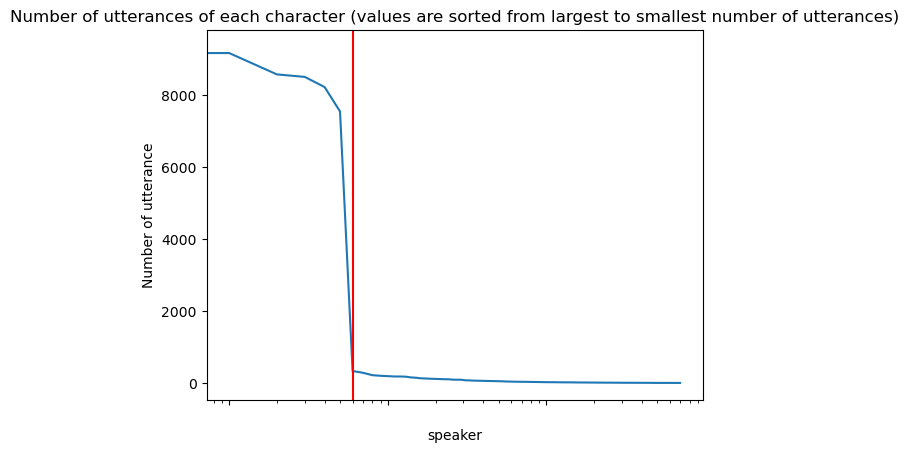

In [9]:
#C 
df.groupby('speaker').size().sort_values(ascending=False).plot(logx=True)
plt.axvline(6, c='r')
plt.title('Number of utterances of each character (values are sorted from largest to smallest number of utterances)')
plt.ylabel('Number of utterance')
plt.xticks(c='w')
plt.show()

In [10]:
main_characters = list(df.groupby('speaker').size().sort_values(ascending=False).head(6).index)

We indeed see a clear drop in the number of utterance after the 6th wordier character.

--- 
**1.3 —** Using `networkx` 

A. Create a `MultiDiGraph` (directed graph with self loops and parallel edges) where:
- Each node $u$ is a character uniquely identified by the `speaker` field.
- There is an edge between nodes $u$ and $v$ if $u$ replied to $v$. If an utterance (a row in the dataframe) is said in reply to nobody, then it will not correspond to an edge. Each edge should contain two attributes. Each edge should have two attributes: `season` and `episode`.

B. Print the number of nodes and edges in your graph.

C. **/Discuss:/** Instead of using multi-edges, what would be another way in which you could capture the number of replies associated with each node pair?


In [11]:
G = nx.MultiDiGraph()

# Creates node attributes
for node in df.speaker.unique():
    G.add_node(node)

# Creates edge attributes
df_replied_speaker = pd.merge(df, df[['id', 'speaker']], how='inner', left_on='reply-to', right_on='id', suffixes=('', '_replied_to'))
for _, edge in df_replied_speaker.iterrows():
    edge = dict(edge)
    if edge['speaker_replied_to'] != 'Nan':
        G.add_edge(edge['speaker'], edge['speaker_replied_to'], season=edge['season'], episode=edge['episode'])


In [12]:
print(f'The number of nodes in the graph is {len(G.nodes)}')
print(f'The number of edges in the graph is {len(G.edges)}')

The number of nodes in the graph is 698
The number of edges in the graph is 54904


C. We could also add another edge attribute refering to the number of reply a specific character as maid to the other one.

---
With the graph ready, you set out to investigate who is the true protagonist of Friends.

Ignore the graph you generated previously and instead use the graph provided in `exam2.graphml`. Note that this graph may be slightly different from what you generated, but treat it as the ground truth. We provide you with code to load the graph below.


In [13]:
import networkx as nx

G = nx.read_graphml("./data/exam2.graphml")

---

**1.4 —** Using the provided MultiDiGraph $G$:

A. Calculate the out-degree of each node (also known as out-degree centrality). Please do not use the `nx.out_degree_centrality` function here, as it normalizes the degree. (E.g., if a node has 5 outgoing edges, it should have out-degree 5 according to your code.)

B. Calculate the PageRank centrality of each node in $G$. Use the default parameters.

C. Print both centrality metrics calculated above for the six main characters of Friends.

D. **/Discuss:/** According to the metrics, who is the most important character in Friends?

In [14]:
out_degrees = pd.DataFrame(G.out_degree)
pagerank = pd.Series(nx.pagerank(G))

In [15]:
print('Out degree centrality of the 6 main character : ')
display(out_degrees.sort_values(by=1, ascending=False).head(6))
print('Page rank centrality of the 6 main character : ')
display(pd.DataFrame(pagerank.sort_values(ascending=False).head(6)))

Out degree centrality of the 6 main character : 


,0,1
5,Rachel Green,8470
4,Ross Geller,8234
2,Chandler Bing,7702
1,Monica Geller,7621
0,Joey Tribbiani,7395
3,Phoebe Buffay,6797


Page rank centrality of the 6 main character : 


,0
Rachel Green,0.126843
Ross Geller,0.125611
Chandler Bing,0.114535
Monica Geller,0.113450
Joey Tribbiani,0.112835
Phoebe Buffay,0.102069


D. Rachel Green have the highest score for both metrics so its seems like she might be the main character of the series if we only consider these metrics.

---

**1.5 —** **/True or false:/** Considering your answer in **1.4**, are the following statements true or false? Justify your answers. 

A. "If we inverted all  edges in the graph such that an edge $(u,v)$ becomes an edge $(v,u)$, the PageRank centrality would remain unchanged."

B. "If we removed all outgoing edges from Rachel Green, her PageRank centrality would remain unchanged."

C. "If a new node was introduced in the graph, with 1,000 outgoing edges towards each other node, but no incoming edge, it would have the highest PageRank centrality."


A. False. To have a high Page Rank centrality as node should receive edges from a lot of other central nodes therefore we consider mainly the in degree of nodes and the direction the edge are thus important.

B. False. Even if the out degree of a node is not directly taken into account to measure the centrality of a node, it indirectly influe on the page rank centrality of the node that themself send inlinks to the node we consider. Thus Rachel Green participate and increases the score of centrality of speakers that then participate and increase back the page rank centrality of Rachel Green.

C. False. If it as no incoming edges then it as a 0 page rank centrality.


---

**1.6 —** Next, you consider how these centrality metrics vary over the course of the seasons.

A. Calculate the PageRank and out-degree centrality of the 6 main characters per episode, i.e., for each episode, create a graph containing only the utterances of that episode and calculate the PageRank centrality for this new graph. Print the PageRank and the out-degree of Rachel Green for the first episode of the first season.

B. Considering the episode-level out-degree centrality of Phoebe Buffay in season 1 and in season 10, print the mean and the standard error of the mean.

C. Create a single plot with 10 inches of width and 4 inches of height. The plot should contain two panels, containing the average PageRank centrality per season of Rachel Green and Ross Geller (Panel A), and the average out-degree per season of Rachel Green and Ross Geller (Panel B). Show 95% confidence intervals in your plot (calculated over the episodes in each season).

D. **/Discuss:/** Does the plot support the hypothesis that Rachel was the show's protagonist in all 10 seasons? Explain why.

In [16]:
out_degrees = {}
pagerank = {}
for episode in df.episode.unique():

    edges_per_episode = [i for i, v in nx.get_edge_attributes(G, "episode").items() if v == episode]
    G_episode = G.edge_subgraph(edges_per_episode)
    tmp1 = pd.DataFrame(G_episode.out_degree).set_index(0)
    tmp2 = pd.Series(nx.pagerank(G_episode))

    out_degrees[episode] = tmp1.loc[main_characters]
    pagerank[episode] = tmp2.loc[main_characters]

In [17]:
out_degrees = pd.concat(out_degrees, axis=1).droplevel(1, axis=1)
pagerank = pd.DataFrame(*[pagerank])

In [18]:
print(f'Mean of out degree centrality of Phoebe Buffay for episode 1 : {out_degrees.loc["Phoebe Buffay", out_degrees.columns.str.contains("s01")].mean():.3f}')
print(f'Std of out degree centrality of Phoebe Buffay for episode 1 : {out_degrees.loc["Phoebe Buffay", out_degrees.columns.str.contains("s01")].sem():.3f}')
print(f'Mean of out degree centrality of Phoebe Buffay for episode 10 : {out_degrees.loc["Phoebe Buffay", out_degrees.columns.str.contains("s10")].mean():.3f}')
print(f'Std of out degree centrality of Phoebe Buffay for episode 10 : {out_degrees.loc["Phoebe Buffay", out_degrees.columns.str.contains("s10")].sem():.3f}')

Mean of out degree centrality of Phoebe Buffay for episode 1 : 23.333
Std of out degree centrality of Phoebe Buffay for episode 1 : 2.201
Mean of out degree centrality of Phoebe Buffay for episode 10 : 36.944
Std of out degree centrality of Phoebe Buffay for episode 10 : 2.809


C. Create a single plot with 10 inches of width and 4 inches of height. The plot should contain two panels, containing the average PageRank centrality per season of Rachel Green and Ross Geller (Panel A), and the average out-degree per season of Rachel Green and Ross Geller (Panel B). Show 95% confidence intervals in your plot (calculated over the episodes in each season).

D. **/Discuss:/** Does the plot support the hypothesis that Rachel was the show's protagonist in all 10 seasons? Explain why.

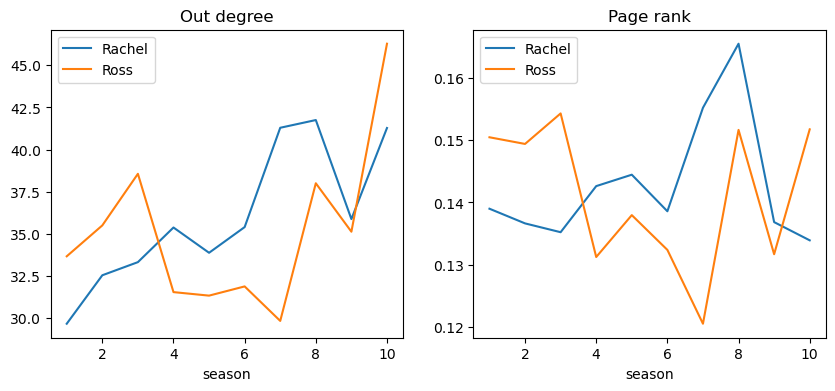

In [24]:
fig, ax= plt.subplots(1, 2, figsize=(10, 4))

seasons = ['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09', 's10']

Rachel_Green_od = pd.Series()
Ross_Geller_od = pd.Series()
Rachel_Green_pr = pd.Series()
Ross_Geller_pr = pd.Series()

for season in seasons:
    Rachel_Green_od.loc[season] = out_degrees.loc["Rachel Green", out_degrees.columns.str.contains(season)].mean()
    Ross_Geller_od.loc[season] = out_degrees.loc["Ross Geller", out_degrees.columns.str.contains(season)].mean()
    Rachel_Green_pr.loc[season] = pagerank.loc["Rachel Green", pagerank.columns.str.contains(season)].mean()
    Ross_Geller_pr.loc[season] = pagerank.loc["Ross Geller", pagerank.columns.str.contains(season)].mean()

ax[0].plot(np.arange(1,11), Rachel_Green_od.values, label='Rachel')
ax[0].plot(np.arange(1,11), Ross_Geller_od.values, label='Ross')
ax[1].plot(np.arange(1,11), Rachel_Green_pr.values, label='Rachel')
ax[1].plot(np.arange(1,11), Ross_Geller_pr.values, label='Ross')

ax[0].set_title('Out degree')
ax[1].set_title('Page rank')

ax[0].set_xlabel('season')
ax[1].set_xlabel('season')

ax[0].legend()
ax[1].legend()





---

**1.7 —** **/True or false:/** Considering your answer in **1.6** are the following statements true or false? Justify your answer. 


A. "In season 7, Rachel Green's episode-level PageRank and out-degree centrality are higher than Ross Geller's. This difference is statistically significant at the 0.05 significance level."

B. "Phoebe Buffay's out-degree grew between season 1 and season 10; this implies that other characters spoke less than her in season 10."

C. "Phoebe Buffay's PageRank was higher in season 10 than in season 1. This difference is statistically significant at the 0.05 significance level and suggests that the character gained importance over the course of the show."


## Part 2: The one about text similarity (40 pts)

Next, you investigate how unique characters are by analyzing what they said throughout the 10 seasons.

**2.1 —** Load the dataframe `exam3.jsonl`. This dataframe is similar to `exam1.jsonl`, except:

- It has an additional column called `tokens`, containing a sentence list. Each sentence is another list composed of tokens, e.g.,
`[['There', "'s", 'nothing', 'to', 'tell', '!'], ['He', "'s", 'just', 'some', 'guy', 'I', 'work', 'with', '!']]`.
- It has an additional column called `episode` containing a unique episode identifier.
- It only contains utterances by Phoebe, Rachel, Ross, Joey, Monica, or Chandler (the main characters).
 
Given this dataframe, you will create an episode-level word-frequency matrix for Chandler Bing, one of the main characters.

A. Create a list $L$ containing all distinct tokens uttered by Chandler Bing throughout the 10 seasons, sorted in ascending order. Print the 10 first and last elements of the list. 

B. Create a matrix $X$ with $m$ rows and $n$ columns, where: $n$ is the number of tokens in the list $L$ that you just created, and $m$ is the number of episodes (236). Each position $X_{i,j}$ in this matrix should contain the number of times the character uttered the word $j$ in episode $i$. Print how many times Chandler uttered the token `joey` in the first episode of the first season, as well as the shape of the matrix $X$.

C. Transform the matrix $X$ into a TF-IDF matrix $T$, combining the following formula (as seen in class):

$$\text{TF}(i,j) = \text{number of times the $j$-th word occurs in the $i$-th episode}$$

$$\text{IDF}(j) =  \log \frac{\text{number of episodes}}{\text{number of episodes in which the $j$-th word occurs}}$$

Print the value in the TF-IDF matrix corresponding to Chandler's utterance of the token `joey` in the first episode of the first season.

D. **/Discuss:/** Some of the tokens (e.g., `joey`) reference other characters. How may these tokens help a classifier predict which character uttered a sentence?

In [173]:
df3 = pd.read_json('data/exam3.jsonl', lines=True)
df3

,id,conversation_id,text,speaker,reply-to,tokens,episode
0,s01_e01_c01_u001,s01_e01_c01_u001,There's nothing to tell! He's just some guy I ...,Monica Geller,None,"[[there, 's, nothing, to, tell, !], [he, 's, j...",s01_e01
1,s01_e01_c01_u002,s01_e01_c01_u001,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,s01_e01_c01_u001,"[[c'mon, ,, you, 're, going, out, with, the, g...",s01_e01
2,s01_e01_c01_u003,s01_e01_c01_u001,"All right Joey, be nice. So does he have a hum...",Chandler Bing,s01_e01_c01_u002,"[[all, right, joey, ,, be, nice, .], [so, does...",s01_e01
3,s01_e01_c01_u004,s01_e01_c01_u001,"Wait, does he eat chalk?",Phoebe Buffay,s01_e01_c01_u003,"[[wait, ,, does, he, eat, chalk, ?]]",s01_e01
4,s01_e01_c01_u006,s01_e01_c01_u001,"Just, 'cause, I don't want her to go through w...",Phoebe Buffay,s01_e01_c01_u005,"[[just, ,, ', cause, ,, i, do, n't, want, her,...",s01_e01
...,...,...,...,...,...,...,...
51307,s10_e18_c11_u017,s10_e18_c11_u000,"Oh, it's gonna be okay.",Chandler Bing,s10_e18_c11_u016,"[[oh, ,, it, 's, gon, na, be, okay, .]]",s10_e18
51308,s10_e18_c11_u018,s10_e18_c11_u000,Do you guys have to go to the new house right ...,Rachel Green,s10_e18_c11_u017,"[[do, you, guys, have, to, go, to, the, new, h...",s10_e18
51309,s10_e18_c11_u019,s10_e18_c11_u000,We got some time.,Monica Geller,s10_e18_c11_u018,"[[we, got, some, time, .]]",s10_e18
51310,s10_e18_c11_u020,s10_e18_c11_u000,"Okay, should we get some coffee?",Rachel Green,s10_e18_c11_u019,"[[okay, ,, should, we, get, some, coffee, ?]]",s10_e18


In [188]:
L = df3[df3.speaker == 'Chandler Bing'].tokens.explode().explode().unique()
L.sort()
print('10 first elements of the list: ')
print(L[:10])
print('10 last elements of the list: ')
print(L[-10:])

10 first elements of the list: 
['!' '!!' '!!!' '!!!!' '!!!!!' '!!!!!!!' '!..' '!...' '!?' '"']
10 last elements of the list: 
['yummy' 'yup' 'zack' 'zero' 'zip' 'zone' 'zoo' 'zorps' '{' '}']


In [212]:
from collections import Counter
def token_count(line, L=L):
    line = [x for xs in line for x in xs]
    c = Counter(line)
    return pd.Series([c.get(v) for v in L])
X = df3[df3.speaker == 'Chandler Bing'].tokens.apply(token_count)

In [218]:
X = X.join(df3.episode, how='left').groupby('episode').sum()

In [233]:
print(f'Shape of X : {X.shape}')
print(f'Number of times Chandler uttered the token `joey` in the first episode of the first season : {int(X.loc["s01_e01"][np.argwhere(L == "joey")[0]].values[0])}')

Shape of X : (236, 6063)
Number of times Chandler uttered the token `joey` in the first episode of the first season : 1


In [243]:
TF_IDF = X * np.log(X.shape[1]/((X > 0).sum(axis=0) + 1))
print(f'TF-IDF value for Chandler uttered the token `joey` in the first episode of the first season : {int(TF_IDF.loc["s01_e01"][np.argwhere(L == "joey")[0]].values[0])}')

TF-IDF value for Chandler uttered the token `joey` in the first episode of the first season : 3


D. **/Discuss:/** Some of the tokens (e.g., `joey`) reference other characters. How may these tokens help a classifier predict which character uttered a sentence?

First, the model may understand that when a character say a name then it is not this character that is speaking so it remove one possibility. Second, if a character tend to speak more to one specific other character then it will also help the model to know which was the character talking just based on the relationship between the subjects.

---
For the remainder of the task, you will use the TF-IDF matrix that we compute below. Note:
- This matrix was calculated in a slightly different way: it considers only the 1000 tokens with the highest term frequency.
- We provide three useful variables below (`X`, `y`, and `df_tfidf`). 
    - `X` is a matrix containing the TF-IDF values for the top 1000 tokens, where each row corresponds to a character in an episode. 
    - `y` indicates which character is responsible for the utterance. Each character has a corresponding number, e.g., 2 for Monica Geller; see dictionary below. 
    - `df_tfidf` is a dataframe combining `X` with other episode and utterance-level metadata.

In [245]:
from sklearn.feature_extraction.text import TfidfVectorizer
df_tfidf = pd.read_json("./data/exam3.jsonl", lines=True)[["speaker", "episode", "text"]]

vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(df_tfidf.text).toarray()
print("X shape", X.shape)


map_char_to_int = {
'Chandler Bing': 0,
'Joey Tribbiani': 1,
'Monica Geller': 2,
'Phoebe Buffay': 3,
'Rachel Green': 4,
'Ross Geller': 5
}


y = df_tfidf.speaker.apply(lambda x: map_char_to_int[x]).values
print("y shape", y.shape)

df_tfidf = pd.concat([df_tfidf[["speaker", "episode"]],  pd.DataFrame(X)], axis=1)

df_tfidf.head(3)

X shape (51312, 1000)
y shape (51312,)


,speaker,episode,0,1,2,3,4,5,6,7,...,990,991,992,993,994,995,996,997,998,999
0,Monica Geller,s01_e01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Joey Tribbiani,s01_e01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Chandler Bing,s01_e01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


--- 

**2.2 —** To compare characters, carry out a classification task. Train a decision tree classifier to predict which main character uttered a sentence..

A. Split the dataset into training and test sets using sklearn `sklearn.model_selection.train_test_split` using parameters `test_size=0.3` and `random_state=42`, and using the default values for all other parameters.


In [246]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


B. Train a decision tree classifier (`sklearn.tree.DecisionTreeClassifier`) using `random_state=42`, leaving all other parameters as their default.


In [247]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)


C. Compute the accuracy of your classifier and of a random baseline, i.e., a classifier that predicts a character uniformly at random. **/Discuss:/** Compare the two accuracies.


In [249]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
accuracy_clf = accuracy_score(y_true=y_test, y_pred=y_pred)

y_rdn = np.random.randint(0,6, size=len(y_test))
accuracy_rdn = accuracy_score(y_true=y_test, y_pred=y_rdn)

print(f'Accuracy of the classifier on the test set : {accuracy_clf:.4f}')
print(f'Accuracy for a random classifier on the test set : {accuracy_rdn:.4f}')

Accuracy of the classifier on the test set : 0.2383
Accuracy for a random classifier on the test set : 0.1704


The accuracy of our classifier is not very high but still larger than the accuracy of a random classifier. However, there might be an inbalance in the dataset regarding the number of utterances of the character and this may biases our results. 



D. Compute the confusion matrix of your classifier using `sklearn.metrics.confusion_matrix`. Normalize the confusion matrix such that all cells sum to 1.


In [252]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='all')


E. Plot an appropriate graphical representation of the confusion matrix.


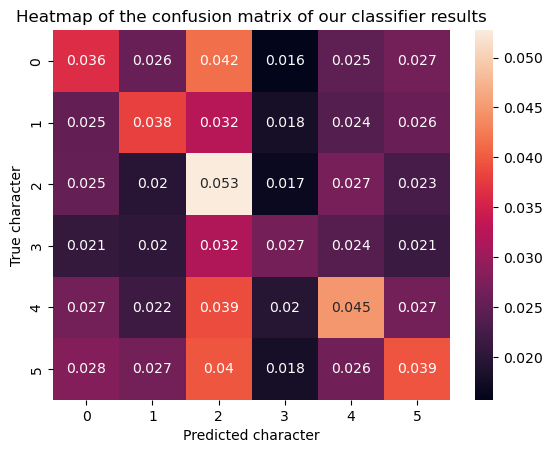

In [255]:
sns.heatmap(confusion_matrix, annot=True)
plt.title('Heatmap of the confusion matrix of our classifier results')
plt.ylabel('True character')
plt.xlabel('Predicted character')
plt.show()


F. **/Discuss:/** Analyzing the confusion matrix, discuss:
   - Which character is most distinct in the way they talk?
   - Which two characters are the most similar in the way they talk?
   - Which two characters are the least similar in the way they talk?


- The character that have the higher true positive score is the 2nd one (Monica Geller), in particular when she's talking the classifier have a low probability of predicting any other character than her so she is the more easily classified.
- Character 0 (Chandler Bing) is often confused with character 2 (Monica Geller) by the classifier (high error rate on this combination) so it seems that Chandler talks a lot like Monica
- Character 0 (Chandler Bing) is very rarely confused with character 3 (Phoebe Buffay) by the classifier as seen by the low value in the confusion matrix. So it seems that the way Chandler speak is very unsimilar to the way Phoebe speaks. 

---

**2.3 —** **/Discuss:/** Last, you discuss the results obtained in **2.2** with a friend, who asks you some thought-provoking questions.

A. Your friend proposes that you should create a measure of similarity between two characters in a given episode in a more direct way than what you've done in **2.2**.  Propose (but do not implement) said similarity metric.

B. Your friend also suggests that your analysis might not truly capture how two characters differ. According to her, if people are in the same conversation, they might speak similarly simply because they are in the same social context. Propose (but do not implement) a way of creating a dataset where this confounder does not exist.

C. Last, your friend complains about how you present your (normalized) confusion matrix. According to her, from reading the cells alone, it is unclear if the fraction of occurrences is higher or lower than what a random classifier would yield. Propose (but do not implement) a way of modifying the confusion matrix to address her concern.


A. 

B. We can repeat the same analysis but by only keeping the conversation where all characters are part and keeping the same number of utterance of each character in these conversations.

C. We can compute the same confusion matrix with the mean of several random classifier and then substract the value of these random classifier from the one we got with the model so that the remaining value only reflect the increase (or decrease) of performance of our classifier compare to a random one.

---